In [22]:
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from shutil import copyfile
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import random 
import datetime
import os 
import dill as pickle
import pandas as pd

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.otherfunctions.multiplot import highlight_cell
from codes.experimentclasses.EthanolAngles import EthanolAngles
from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from einops import rearrange


In [23]:

#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#these are just for loading... probably not necessary
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/malonaldehyde_110120_nsel100_nreps25.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

# new_MN = True
# new_grad = True
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

# new_MN = True
# new_grad = True
# if new_MN == True:
#     experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
#     projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
#     experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
#     experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
#     experiment.q = m
#     experiment.m = m
#     experiment.dimnoise = dimnoise
#     experiment.projector = projector
#     experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
#     experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [88]:
def get_cos_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                #if ind[j] != k:
                coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    
    return (coses)


def get_incoherent_dictionary_include(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))

def get_incoherent_dictionary_include_median(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.median(np.linalg.norm(dg_M[:,:,keepers], axis = tuple([1])), axis = 0).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

def get_kappa_s(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    kappa_i = np.max(kappa_ij, axis = 1) / np.min(kappa_ij, axis = 1)
    kappa = np.max(kappa_i)    
    return(kappa)

def get_coses_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def get_mu_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses.max())

def get_min_min(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    min_min = np.min(kappa_ij)
    return(min_min)

def get_gamma_max(dg_M):
    output = np.sum(np.sum(dg_M**2, axis = 1), axis = 0).max()
    return(output)

# def get_cosines(self, dg):
def get_cosines_full(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    coses = np.zeros((n, p, p))
    for i in range(n):
        #print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

# def get_cosines(self, dg):
def get_cosines2(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)
#coses = get_cosines2(np.swapaxes(replicates[0].dg_M,1,2))

# def get_cosines(dg):
#     n = dg.shape[0]
#     p = dg.shape[1]
#     d = dg.shape[2]

#     coses = np.zeros((n, p, p))
#     for i in range(n):
#         print(i)
#         for j in range(p):
#             for k in range(p):
#                 coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
#     # cos_summary = np.abs(coses).sum(axis = 0) / n
#     cos_summary = np.sum(coses ** 2, axis=0) / n
#     return (cos_summary)

In [26]:
trueandsel = np.asarray([74, 176, 746, 665])

In [28]:
#np.linalg.norm(results[0].dgw_norm[:,665,:], axis = 0)

In [29]:
np.linalg.norm(replicates[0].dg_M, axis = tuple([1,0]))[trueandsel]

array([48.74165425, 64.17550218, 73.8647704 , 61.15457066])

In [30]:
# with open('/homes/sjkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_010721_pallrep5n100replicates.pkl' ,
#          'rb') as loader:
#      results = pickle.load(loader)

In [31]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_010721_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_010721_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [93]:
include = np.asarray([74,176])
thresh = .2
incoherent_indices = {}
nreps = 5
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
incoherent_indices

r = 0
sub = incoherent_indices[r]
xs = np.swapaxes(replicates[r].dg_M[:,:,sub],1,2)

nsub = len(sub)
cosine_similarities = np.zeros((100,nsub,nsub))
for i in range(100):
    for j1 in range(nsub):
        for j2 in range(nsub):
            cosine_similarities[i,j1,j2] = cosine_similarity(xs[i,j1],xs[i,j2])

rds = rearrange(xs[:,:,:], 'n p d -> (n d) p')
csmean = np.abs(np.mean(cosine_similarities, axis = 0))

cosine_similarities_real = np.zeros((nsub,nsub))
for j1 in range(nsub):
    for j2 in range(nsub):
        cosine_similarities_real[j1,j2] = cosine_similarity(rds[:,j1],rds[:,j2])



(100, 2, 756)
11
(100, 2, 756)
11
(100, 2, 756)
9
(100, 2, 756)
8
(100, 2, 756)
9


In [109]:
incoherent_indices[0]

array([ 74, 176, 746, 584, 564, 650, 665, 686, 648, 513,  93, 339, 100,
        37])

In [113]:
cosine_similarities[:,0,2]

array([-0.85720512, -0.99433143, -0.9678513 ,  0.97208835,  0.99487172,
       -0.87880852, -0.99377766, -0.98722966,  0.88129018,  0.98783118,
        0.99239691,  0.93880296, -0.83880327, -0.82514868,  0.80386345,
       -0.97047964, -0.94848829, -0.89420677, -0.94413024, -0.91151029,
        0.97812937,  0.99965984, -0.98095795,  0.99997633,  0.8065102 ,
       -0.96148988, -0.97123038,  0.998716  , -0.98803596,  0.9814658 ,
        0.99885619, -0.99388263, -0.91089467, -0.95136437,  0.9960686 ,
        0.95867766, -0.99216865,  0.98972754,  0.82631798,  0.91006205,
        0.98113302,  0.99899962,  0.944522  ,  0.97029228, -0.90499694,
       -0.98323926, -0.9974159 , -0.99327652, -0.92072491, -0.99547889,
       -0.99346952, -0.99757706,  0.9348181 ,  0.98752123,  0.94864297,
       -0.98023297,  0.98362023, -0.98401642,  0.99834126,  0.89483751,
       -0.8830265 ,  0.99457147,  0.86668541,  0.92573767, -0.953563  ,
        0.8863409 ,  0.90887484,  0.96686332, -0.99393761, -0.99

Text(0.5, 1.0, 'Cosines')

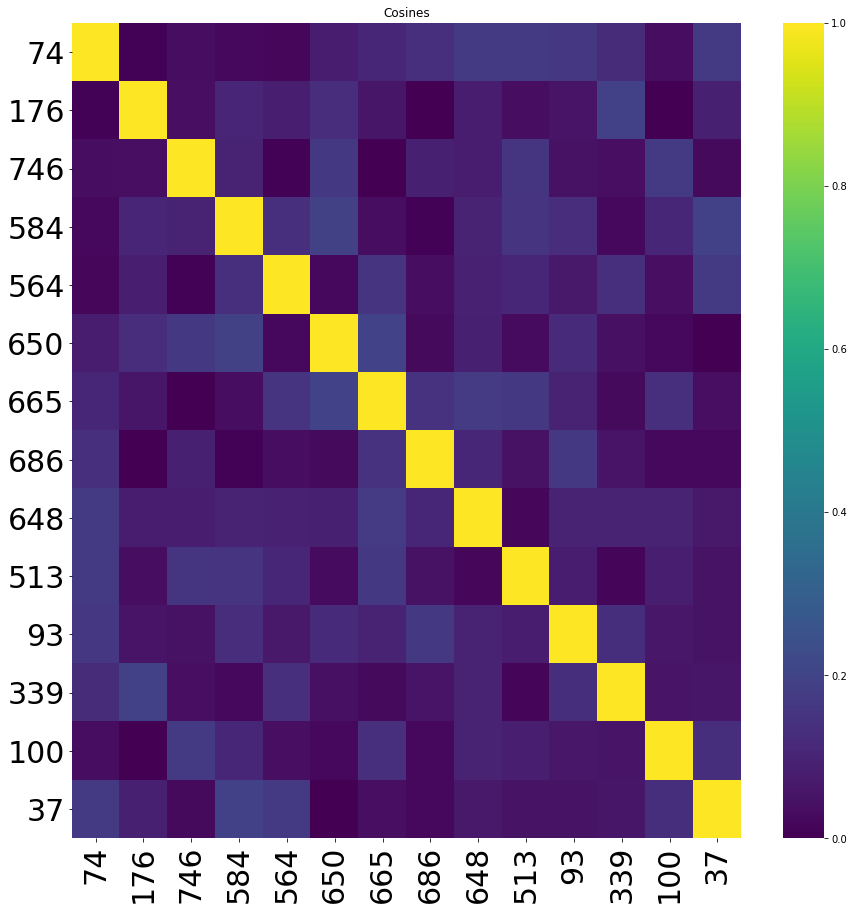

In [96]:
fig , ax = plt.subplots(1,1,figsize = (15,15))
sns.heatmap(csmean, vmin = 0., vmax  = 1., cmap = 'viridis', ax = ax)
ax.set_xticklabels(sub, fontsize = 30, rotation = 90)
ax.set_yticklabels(sub, fontsize = 30, rotation = 0)
ax.set_title('Cosines')

In [32]:
#     incoherent_indices = include
#     r = 4
#     dg_M = replicates[r].dg_M
    
#     #dg_M_down = 
#     keepers = np.asarray(list(range(dg_M.shape[2])))
#     coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
#     print(coses.shape)
#     cos_mean = coses.mean(axis = 0)
#     keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    

In [33]:
#     for i in range(dg_M.shape[2]):
#         print(keepers.shape)
#         #print(i)
#         id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         ind_add = keepers[id_add]
#         print(ind_add)
#         incoherent_indices = np.append(incoherent_indices, ind_add)
        
#         #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
#         #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
#         coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
#         #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
#         #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
#         keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
#         #print(keepers)
#         if len(keepers) == 0:
#             #print(i)
#             break
            

In [36]:
#selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

p = replicates[0].dg_M.shape[2]
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

#thresh = .8
#incoherent_indices = {}
#nreps = 5
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 1053.2541271372268
0 526.6270635686134 probe
converged 526.6270635686134
1 789.9405953529201 probe
2 658.2838294607668 probe
converged 658.2838294607668
3 724.1122124068435 probe
converged 724.1122124068435
we did it [2 6]
initializing lambda search
converged 1086.9616365071163
0 543.4808182535581 probe
converged 543.4808182535581
1 815.2212273803373 probe
converged 815.2212273803373
2 679.3510228169478 probe
converged 679.3510228169478
3 747.2861250986425 probe
converged 747.2861250986425
we did it [2 4]
initializing lambda search
converged 1068.136473243027
0 534.0682366215135 probe
1 801.1023549322703 probe
converged 801.1023549322703
2 667.5852957768918 probe
converged 667.5852957768918
we did it [2 6]
initializing lambda search
converged 1065.5080862339685
0 532.7540431169842 probe
converged 532.7540431169842
1 799.1310646754764 probe
converged 799.1310646754764
2 665.9425538962303 probe
converged 665.9425538962303
we did it [2 3]
initializing 

In [37]:
nreps = 5
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [103]:
#pretty slow
#g_mf = np.zeros((5,2,50000))
selections  = np.zeros((2,5))
for r in range(nreps):
    for o in range(2):
        #print(o)
        #g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[incoherent_indices[r][sel[r]][o]])
        selections[o,r] = incoherent_indices[r][sel[r]][o]

In [104]:
selections

array([[746., 721., 722., 746., 722.],
       [665., 649., 405., 602., 649.]])

In [34]:
experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)

In [39]:
experiment.q = m
experiment.m = m
experiment.dimnoise = dimnoise
experiment.projector = projector
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [151]:
#pretty slow
a4, p = get_all_atoms_4(9)
g_mf_inc2 = np.zeros((5,2,50000))
for r in range(nreps):
    for o in range(2):
        print(o)
        g_mf_inc2[r,o] =  experiment.get_g_full_sub(experiment.M.data, a4[incoherent_indices[r][sel[r]][o]])

0
1
0
1
0
1
0
1
0
1


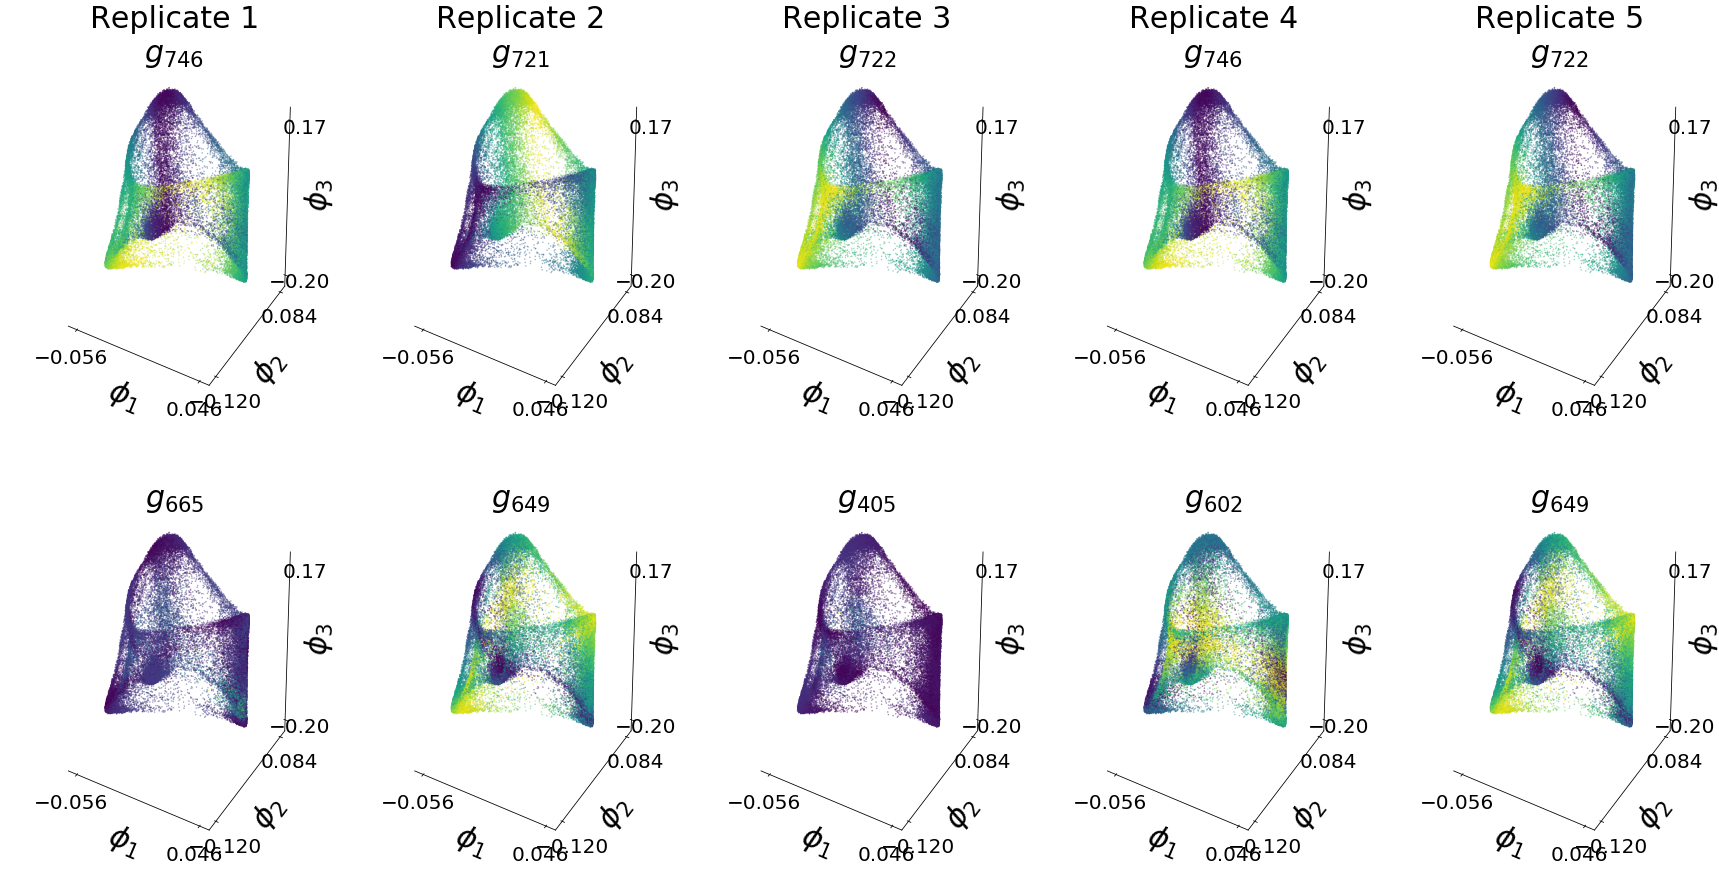

In [152]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf_inc2[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 30)
        ax.set_ylabel(r'$\phi_2$', fontsize = 30)
        ax.set_zlabel(r'$\phi_3$', fontsize = 30)
        
        if o ==0:
            ax.set_title('Replicate ' + str(r+1) + '\n' + r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][0]]), fontsize = 30)
        if o == 1:
            ax.set_title(r'$g_{{{}}}$'.format(incoherent_indices[r][sel[r][1]]), fontsize = 30)
        #ax.set_axis_off()
        xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
        xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
        ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
        ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
        zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
        zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
        ax.set_xticks([xmin, xmax])
        ax.set_yticks([ymin, ymax])
        ax.set_zticks([zmin, zmax])
        ax.tick_params(labelsize=20)

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_full_sup_mflasso')

In [107]:
a4[649]

array([5, 2, 6, 8])

In [64]:
#for r in range(1):
r = 0
groupcors = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2]))
output = np.argsort(-groupcors)
#print(np.asarray([incoherent_indices[r][output[:10]], groupcors[output[:10]]]).transpose())
    

In [66]:
groupcors[trueandsel]

array([ 701.23558216,  713.2878901 , 1053.25412714,  814.89559763])

In [60]:
with open('/Users/samsonkoelle/Downloads/ethanol_010721_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)
        
with open('/Users/samsonkoelle/Downloads/ethanol_010721_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


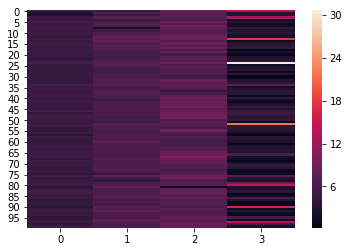

In [51]:
trueandsel = [74,176,746,665]
norms = np.linalg.norm(replicates[0].dg_M[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

In [52]:
norms[:,3][norms[:,3].argmax()]

30.624042693504006

In [53]:
r = 0
ptnorm = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,np.asarray(trueandsel)]), axis = tuple([2]))
#np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M[:,:,:] , replicates[r].dg_M[:,:,[74,176,708,738]]))

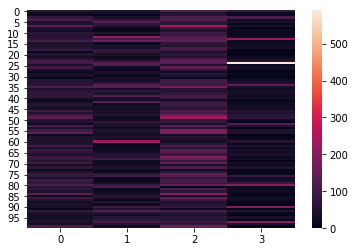

In [54]:
sns.heatmap(ptnorm)

In [71]:
ptnorm[:,3][24], np.sqrt(np.linalg.norm(ptnorm[:,3])**2 - 590**2)

(590.0802199957201, 562.0985990283451)

In [73]:
# r = 0 
# np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2]))

In [ ]:
# nreps = 5
# saves = np.zeros((5,5))
# for r in range(nreps):
#     saves[r] = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2]))[subset_l0]

In [53]:
#reorder lambdas and coefficients
# for r in range(5):
#     cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
#     xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
#     xaxis_reorder = xaxis[xaxis.argsort()]
#     cs_reorder = cs[xaxis.argsort()]
#     xaxis_reorder = xaxis[xaxis.argsort()]
#     replicates[r].cs = cs
#     replicates[r].cs_reorder = cs_reorder
#     replicates[r].xaxis_reorder = xaxis_reorder
#     replicates[r].xaxis = xaxis


# #get selection lambda
# nreps = 5
# sel_l = np.zeros(nreps, dtype = int)
# for r in range(5):
#     for l in range(replicates[r].cs_reorder.shape[0]):
#         zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
#         if len(zeros) == 2:
#             sel_l[r] = l
#             #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))


# #get almost selection lambda
# almost_sel = {}
# sel = {}
# min_sel = {}
# for r in range(5):
#     print('s')
#     almost_sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
#     sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
#     print('a')
#     min_sel[r] =  np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[1] !=0.)[0]
# #sel_total = almost_sel

# #subset

# subset = np.unique(np.hstack([np.concatenate(list(almost_sel.values())),np.concatenate(list(sel.values())) ]))
# psmallest = len(subset)

# to_plot = np.zeros((psmallest, psmallest))
# nreps = 5
# for r in range(nreps):
#     i_smallest = np.where(subset == sel[r][0])[0]
#     j_smallest = np.where(subset == sel[r][1])[0]
#     to_plot[i_smallest,j_smallest] +=1
#     to_plot[j_smallest,i_smallest] +=1
    
# names = np.zeros(len(subset), dtype = object)
# for s in range(len(subset)):
#     names[s] = r"$g_{{{}}}$".format(subset[s])

# cmap = plt.get_cmap('brg',len(subset))

# colors_subset = np.zeros((len(subset),4))
# for s in range(len(subset)):
#     colors_subset[s] = cmap(s)

subset_l0 = np.unique(np.asarray(list(sel.values())))


In [74]:
for r in range(5):
    
    print(incoherent_indices[r][sel[r][0]], incoherent_indices[r][sel[r][1]])

746 665
721 649
722 405
746 602
722 649


In [77]:
#sub = np.asarray([74,176, 405,602,605,632,722,745])


In [85]:
csmean[1,5]

0.17705609816960582

Text(0.5, 1.0, 'Cosines')

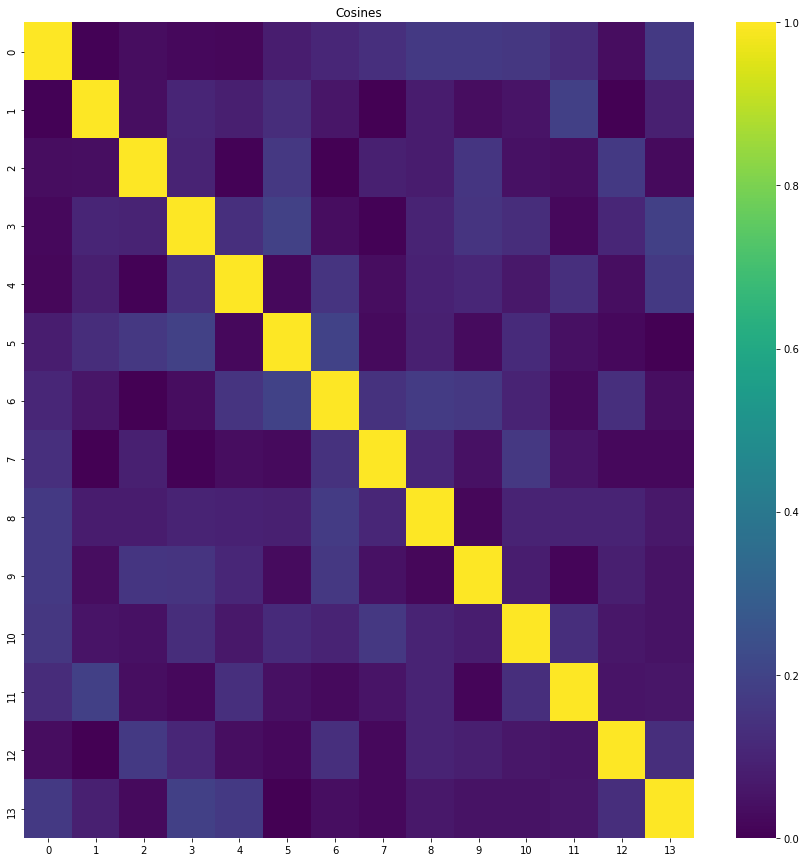

In [11]:
include = np.asarray([74,176])
thresh = .2
incoherent_indices = {}
nreps = 5
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_include_median(replicates[r].dg_M, thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]

(100, 2, 756)
12
(100, 2, 756)
10
(100, 2, 756)
10
(100, 2, 756)
8
(100, 2, 756)
9


In [12]:
incoherent_indices

{0: array([ 74, 176, 745, 564, 152, 732, 651, 648, 513, 153, 665,  96, 339,
        110,  37]),
 1: array([ 74, 176, 722, 596, 580, 387, 404, 363, 659, 647, 100, 108,  41]),
 2: array([ 74, 176, 722, 212, 688, 674, 569, 402, 648, 405, 336, 112,  96]),
 3: array([ 74, 176, 746, 564, 686, 602, 404, 653,  90,  40,  95]),
 4: array([ 74, 176, 722, 564, 152, 404, 318, 628, 417,  99, 108,  36])}

In [13]:
#selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

p = replicates[0].dg_M.shape[2]
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

#thresh = .8
#incoherent_indices = {}
#nreps = 5
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 1056.5542834831997
0 528.2771417415998 probe
1 792.4157126123998 probe
converged 792.4157126123998
2 660.3464271769999 probe
converged 660.3464271769999
3 726.3810698946999 probe
converged 726.3810698946999
we did it [ 2 10]
initializing lambda search
converged 1069.354373519881
0 534.6771867599405 probe
converged 534.6771867599405
1 802.0157801399107 probe
converged 802.0157801399107
2 668.3464834499256 probe
converged 668.3464834499256
3 735.1811317949182 probe
converged 735.1811317949182
we did it [2 7]
initializing lambda search
converged 1068.136473243027
0 534.0682366215135 probe
1 801.1023549322703 probe
converged 801.1023549322703
2 667.5852957768918 probe
converged 667.5852957768918
we did it [2 9]
initializing lambda search
converged 1065.5080862339685
0 532.7540431169842 probe
converged 532.7540431169842
1 799.1310646754764 probe
converged 799.1310646754764
2 665.9425538962303 probe
converged 665.9425538962303
we did it [2 5]
initializing

In [14]:
nreps = 5
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [18]:
for r in range(5):
    print(incoherent_indices[r][sel[r]])

[745 665]
[722 363]
[722 405]
[746 602]
[722 404]


In [16]:
#pretty slow
a4, p = get_all_atoms_4(9)
g_mf_inc2 = np.zeros((5,2,50000))
for r in range(nreps):
    for o in range(2):
        print(o)
        g_mf_inc2[r,o] =  experiment.get_g_full_sub(experiment.M.data, a4[incoherent_indices[r][sel[r]][o]])

0


NameError: name 'experiment' is not defined